In [1]:
import numpy as np
import scipy.stats
import scipy.optimize
import matplotlib.pyplot as plt

# iPython magic command for inline figures. If this command is not given, figures are generated in windows.
# An asterisk appears in the cell prompt (i.e. "In [*]:"), and the kernel stalls until the window is closed.
%matplotlib inline

## Below are two simple examples of exception handling

## Try to import pandas. If not existent, set flag = False, and raise an exception.
try:
    import pandas as pd
    pd_flag = True
except ImportError:
    print("Package pandas not found. Cannot do funky data structures!")
    pd_flag = False
    
## Try to import seaborn.
try:
    import seaborn as sns
    sns_flag = True
    sns.set_style("whitegrid")
    sns.set_style("ticks")
except ImportError:
    sns_flag = False
print("Does seaborn exist on the computer? " + str(sns_flag))

Does seaborn exist on the computer? True


## Significance tests

### How many sigmas?

It is quite common, especially in experimental physics, to quote significance (or confidence levels/intervals, see later) in terms of a number of *sigmas*. The sigma value ($\sigma$) corresponding to a given $p$-value is simply the number of standard deviations of a standard normal distirbution which exclude an integrated probability equal to the $p$-value. I.e. $p$-value = Pr$\left(\left|x\right|\ge{z}\mid\mu = 0, \sigma^2=1\right)$ (remembering that the probability is calculated on both sides of the distribution, hence the modulus for the $x$). A sigma value for a given $p$-value or vice versa can be quickly calculated using the standard normal distribution in `scipy.stats`:

In [2]:
def sigmas_to_p(sigval):
    nd = scipy.stats.norm(0., 1.)
    return 2.*nd.sf(sigval)

def p_to_sigmas(pval):
    nd = scipy.stats.norm(0., 1.)
# We use the 'inverse survival function', the inverse of the cdf. We also need to divide
# our p-value by 2 to account for the negative side of the normal distribution.
    return nd.isf(pval/2.)

print "3-sigma corresponds to p =",sigmas_to_p(3.)
print "5-sigma corresponds to p =",sigmas_to_p(5.)

print "p-value of 0.05 corresponds to",p_to_sigmas(0.05),"sigma"
print "p-value of 0.01 corresponds to",p_to_sigmas(0.01),"sigma"

3-sigma corresponds to p = 0.00269979606326
5-sigma corresponds to p = 5.73303143758e-07
p-value of 0.05 corresponds to 1.95996398454 sigma
p-value of 0.01 corresponds to 2.57582930355 sigma


### The t-test: revisiting Michelson's speed-of-light data

Let's recycle and hack some of the code we used from Week 1 (originally to split up the data to calculate statistical quantities separately for each experiment).  Using the known speed of light (299000+792.5 km/s) for our population mean, we obtain t-statistics and p-values for the 1-sample t-statistic as follows:

In [3]:
morley = np.loadtxt("morley.txt", skiprows=1)
run = morley[:,1]
speed = morley[:,2]
experiment = morley[:,3]
tstat_all = []
pval_all = []

## Loop over all experiments and print and write t-statistic and p-value to arrays
for s in set(experiment):
    t = scipy.stats.ttest_1samp([sp for sp, ex in zip(speed, experiment) if ex == s],popmean=792.5)
    tstat_all.append(t[0])
    pval_all.append(t[1])


print tstat_all
print pval_all

[4.9654389239836041, 4.6429265580097852, 2.9679745623106557, 2.0855489836268042, 3.2168097562039608]
[8.5882359808904746e-05, 0.00017737602466599627, 0.0079020388900592296, 0.050744221966327455, 0.0045397743952858846]


Collectively, it is clear that these experiments give values for the mean which are systematically too high compared to the expected value.  Note that if the t-statistics were negative, that would imply values of the mean which were <i>lower</i> than the expected value.  For the t-statistic, the absolute value conveys the size of the deviation, but the sign tells us the direction, thus the t-test is a <i>two-sided test</i>.  To see what this means in terms of the <i>p</i>-value, let's look at the result from the 4th experiment (with the least significance).

We can plot the obtained t-statistic (2.0855...) on the corresponding t-distribution, which is for 19 degrees of freedom (d.o.f.), since the d.o.f. $\nu=n-1$ where $n$ is the number of measurements used to obtain the mean, in this case $n=20$ (i.e. per experiment):

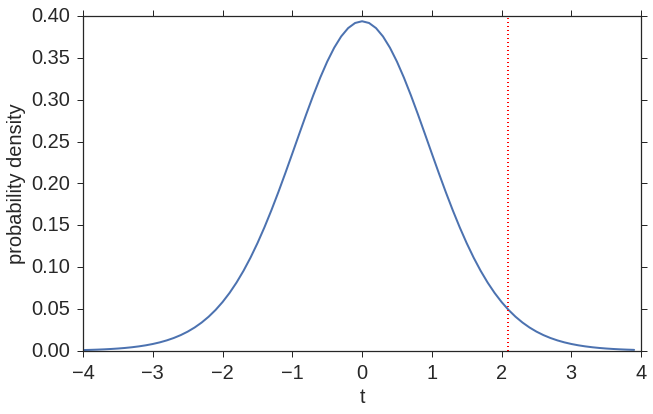

In [4]:
## First freeze the distribution for the given degrees of freedom (which is the only 'shape parameter' of the 
## distribution)
t = scipy.stats.t(df=19)

## Now lets plot the pdf, together with a vertical line marking the measured value of the t-statistic:
fig, ax1 = plt.subplots(1, figsize=(10,6))
x = np.arange(-4.0, 4.0, 0.1)
ax1.plot(x, t.pdf(x), lw=2)
plt.axvline(x=tstat_all[3], ymin=0.0, ymax = 1.0, linewidth=2, linestyle='dotted', color='red')
ax1.set_xlabel("t", fontsize=20)
ax1.set_ylabel("probability density", fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
plt.show()

For our significance test we need to properly frame the question in terms of the null hypothesis.  What is the null hypothesis and the corresponding question we must answer in this case?

<b>"Assuming that the true (population) mean is 299792.5 km/s, what is the probability that we would see such an extreme (or more extreme) value of the <i>t</i>-statistic from the data (assuming that the errors are normally distributed)?"</b>

What do we mean by "such an extreme value"?  We are talking about how far the sample mean is from the assumed population mean (normalised by the standard error), thus larger <i>absolute</i> values of the t-statistic (either negative or positive) are classed as more extreme (i.e. the t-test is a 2-sided test).  Since we would be even more surprised to obtain even larger absolute values of $t$ than we observe <i>if the assumed population mean is correct</i>, we want to know the probability that $|t|\ge |t_{\rm observed}|$.  This is our p-value.  Thus for the 4-th experiment we can recover the $p$-value by integrating the $t$-statistic over these extrema, using the appropriate suffix on our function:

In [5]:

2*scipy.stats.t.sf(2.0855, 19, loc=0, scale=1)

0.05074913167449141

Which can be compared with the value already given by the 'scipy.stats.t' function.

How should we report the significance of our results?  It depends on the context: how big a deal is it if the null hypothesis is wrong?  If you are trying to test whether the speed-of-light is really variable, it is unlikely that anybody would accept anything less than 5-sigma ($p\sim 6\times 10^{-7}$ or almost 1 in 2 million), and even then would suspect a systematic error in the experiment as the likely origin of the deviation (the process would then move on to replication by other groups and with different experimental set-ups).  

More likely, we are curious about more mundane effects, e.g. are we looking to check something which is already suspected or known or is fairly plausible versus our null hypothesis in the light of other evidence? In this case, given we know how much evidence there is for the speed-of-light being constant (this is our 'inner Bayesian' talking, even if we don't know it!) we may suspect that there a systematic error in the experimental measurements, and would accept much lower significances as evidence for this.  Typically then, we look at what is the nearest appropriate significance limit <i>below</i> the obtained value.  The limits can then be quoted as a sigma value, or in terms of a percentage given by $1-p$ (which is our <b><i>confidence</i></b> that the null hypothesis is disproven).  

A bare minimum for claiming significance is either the 95~per cent confidence level (common to many fields and seen as a potential cause of high publication of false results), or more robustly, 3-sigma (99.7 per cent confidence).

So, looking at each experiment above, what is the significance of each deviation from the known speed of light?

Experiment 1:  

Experiment 2:  

Experiment 3:  

Experiment 4:  

Experiment 5:  

### The $\chi^{2}$ test

Now we examine the chi-squared test.  Here we must assume an underlying model which describes the expected value ($y_{\rm mod}$) of each data point (at a value of the explanatory variable, $x$).  Assuming that the model and its parameters are correct and the errors on the data points are independent and normally distributed, the sum of the squared, weighted (by the error) residuals will follow a $\chi^{2}$ distribution with $\nu$ degrees of freedom.  $\nu = n-m$ where $n$ is the number of data points and $m$ the number of <i>free</i> (i.e. allowed to vary) parameters in the model. 

First let's define a function for calculating the summed weighted least-squares.  We will do this in a general way so we can use it again later:

In [6]:
def ChiSq(parm, xval, yval, dy): # the weighted least-squares
    ymod = my_model(xval, parm) # model to be specified by a different function
    return sum(pow((yval-ymod)/dy,2))

To demonstrate the test, we will assume the null hypothesis that the values of the speed of light measured by Michelson's experiments are consistent with a constant value equal to the mean of the five measurements.  Thus we are effectively checking the idea that the measurements are consistent with one another and the <i>observed</i> mean, i.e. there is no systematic error between experiments. 

In [7]:
##  First we calculate the mean and standard error for each experiment
yval = []
yerr = []
for s in set(experiment):
    mean = np.mean([sp for sp, ex in zip(speed, experiment) if ex == s])
    err = scipy.stats.sem([sp for sp, ex in zip(speed, experiment) if ex == s])
    yval.append(mean)
    yerr.append(err)

##  Now define a 'model' by calculating the mean - parm is just used to substitute the y values here
parm = yval
def my_model(xval, parm):
    return np.mean(parm)

##  Now determine and print chi-squared:
xsq_obs = ChiSq(parm,s,yval,yerr)
print xsq_obs


14.6812491089


How many degrees of freedom are there?  We have $n=5$ data points.  At face value, the model has <i>no</i> free parameters - the model is given by the mean which is a fixed value.  However, it is fixed by the data, equivalent in some sense to a best-fit and so we would be right to assume that $m=1$, thus there are 4 degrees of freedom.  We can now plot our measured value on the $\chi^{2}_{4}$ pdf:

In [8]:
### Plot the pdf and measured value

We can already see from the figure that our observed value is well in the tail of the distribution.  Note that the chi-squared test is a 1-sided test: smaller values lie closer to the null hypothesis not further away, so if we want to test whether the data are consistent with the null-hypothesis (the assumed model), we should ask what is the probability that an equal or larger value of chi-squared would be observed by chance, if the model is correct:

In [9]:
### Print the p-value


Thus our confidence that the null hypothesis is false (i.e. the experimental results are in fact <b>not</b> consistent between experiments) is greater than 99 per cent, but still just less than 3-sigma.

It's interesting to consider the case where our observed chi-squared was significantly small, compared to the number of degrees of freedom.  E.g. if the observed chi-squared was 0.2 in the above example, we would be in the far left tail of the distribution, supporting the null hypothesis but also unlikely ($<1$ per cent) to occur by chance.  Of course, low-probability events do happen (especially at modest but not extreme probabilities), but we might still start to suspect that the error bars are somehow overestimated, and look into this possibility.

## Maximum likelihood estimation

Maximum likelihood estimation is the process of fitting models to data so that we can find the best-fitting model parameters (the <i>Maximum Likelihood Estimates</i> or <i>MLEs</i>), along with (potentially) an estimate of the goodness-of-fit of the model.  The methods can also be extended to provide confidence intervals ('error bars') on our model parameters, and also to compare different (but related) models to determine which provides the best description of the data (hypothesis testing).  We will investigate these aspects of maximum likelihood estimation in the next couple of weeks, but first we examine how to use likelihood functions combined with the suite of powerful optimisation tools in Python, in order to fit models to data and estimate the goodness-of-fit.

### Likelihood functions: Log-likelihood and weighted least-squares

Before proceeding to fitting we must first define our likelihood function. Here we follow Vaughan and define a couple of possible functions: the negative log-likelihood and the weighted least-squares (i.e. to get the $\chi^{2}$ statistic). In both cases we need to minimise the function to find the MLEs. You can choose your own form of the likelihood function to suit the data you need to fit. The negative log-likelihood calls our model and then sets up the normal distribution with a mean given by the model prediction for $y$ and a standard deviation equal to the assumed error, $dy$. We can then obtain the likelihoods from the pdf of our normal distribution. This form of the likelihood function is very flexible, since instead of a normal distribution we can choose other distributions that may be better suited to our data, i.e. a more appropriate 'statistical model' (most likely the Poisson distribution, which we will look at next week).   

We have already seen the weighted least-squares approach in the form of the significance test: this function is essentially the same as the one used for the test (the underlying statistical principles are the same, and this will give us the ability to assign a confidence or 'goodness-of-fit' to our best-fitting model). This is a much simpler likelihood function, but remember that it is only applicable in the case where the errors are normally distributed!

In [10]:
def LogLikelihood(parm, xval, yval, dy): # the -ve log-likelihood
    ymod = my_model(xval, parm)  #We define our 'physical model' separately
    nd = scipy.stats.norm(ymod, dy) #we define our normal distribution
    return -sum(np.log(nd.pdf(yval)))

def ChiSq(parm, xval, yval, dy): # the weighted least-squares
    ymod = my_model(xval, parm)
    return sum(pow((yval-ymod)/dy,2))

### Fitting a constant to the speed of light data

We'll first look at a very simple example of fitting a model to data, specifically, we are going to find the constant value which best-fits the combined means (and errors) of the five Michelson experiments.  First define the model:

In [11]:
parm = np.zeros(1)  ## First set parm to be a 1-element array - we will set the value later
def my_model(xval, parm):
    return parm[0]

Of course, our model is very simple and you could easily find a Python function to do the same job, but being able to define your own models allows you to do ML estimation for much more complex data.  

Since we have set up our estimator - the log-likelihood or weighted least-squares - for our model, we can minimise it to find the best fitting parameters. For this we use the `scipy.optimize` module, specifically the minimize function. Besides giving this function the name of our likelihood function and the parameters to be varied to find their MLEs, we also provide the other variables used by the likelihood function (i.e. the data!) in the `args` parameter. 

As described in the Tutorial lecture slides, there are many options to choose from.  For simple minimisation where we aren't interested in outputting the Jacobian or Hessian (useful for estimating confidence intervals: see next week), we can use one of the standard functions like Nelder-Mead with `minimize`.
Nelder-Mead also does not require a Jacobian to be specified for our physical model function (the gradient information in the Jacobian is used by some minimisation methods to help find the minimum). There are many more options which can be found in the documentation of the `scipy.optimize` module and associated documentation for the `minimize` function. The question of how best to do minimisation is complex and it very much depends on the type of data, models and your own computational resources, so it is best to read further on the topic if you have a specific problem to solve.  We will look at some further examples 

Now we'll import the `scipy.optimize` package to make the function calls simpler.  Then we will set up our starting parameters and call the optimisation function. 

In [12]:
import scipy.optimize as op

## First set the starting values of model parameters.  It depends on the model function used, 
## but in general you should make sure these aren’t way off the expected values or the optimisation may get stuck
## - this doesn’t mean you need to know the values already, just choose something
## that seems plausible given the data.

parm[0] = 800.
## We can recycle the means and standard errors calculated earlier in the notebook, for clarity we also
## set the xval to the experiment number, but note in this case that the model is not a function of this value
## (in most other situations, the model for y will depend on x)
xval = [1, 2, 3, 4, 5]

## Now the optimisation function: we can also change the function called to ChiSq
## without changing anything else, since the parameters are the same.

result = op.minimize(LogLikelihood, parm, args=(xval, yval, yerr), method="Nelder-Mead")
# print result
## The minimize function outputs the array of best-fitting parameters (x) and the value of the function minimised 
## e.g. the -ve Log-likelihood, or the chi-squared.

mle = result["x"]
mlval = result["fun"]
print "-ve log-likelihood fit results:"
print "Best-fitting constant = " + str(mle[0]) + " with -ve log-likelihood = " + str(mlval)+"\n"

## Changing to weighted-least squares...
result = op.minimize(ChiSq,parm,args=(xval,yval,yerr),method="Nelder-Mead")
mle = result["x"]
mlval = result["fun"]
dof = len(xval)-len(parm)
print "CHISQ fit results:"
print "Best-fitting constant = " + str(mle[0]) + " with chiSQ = " + str(mlval) + " dof = " + str(dof)


-ve log-likelihood fit results:
Best-fitting constant = 842.679595947 with -ve log-likelihood = 24.5987872964

CHISQ fit results:
Best-fitting constant = 842.679595947 with chiSQ = 12.5354654002 dof = 4


It's interesting to note that the best-fitting constant to the data here is significantly different from the mean of all the data (852.4) calculated previously.  This is because it has been weighted by the standard error on the mean for each experiment, with the experiments with greater scatter in their recorded values contributing less to the model fit.  As a result of this, the chi-squared value is also significantly smaller than the value we obtained earlier for the unweighted mean.  

With the output of the weighted least-squares fit, we can go further and estimate the significance using the $\chi^{2}$ distribution for 4 d.o.f. (5 data points - 1 free parameter in the model).  This is our <i>goodness-of-fit</i>.  Calculate it using the function you used earlier - clearly the obtained constant is a much better estimator of the underlying mean of the experiment, and the goodness-of-fit implies that the experiments are in fact consistent with a single mean value (although one which is systematically too high compared to the true value of the speed-of-light).

You can feel free to experiment with using other methods for fitting beyond Nelder-Mead, but note that in this case, for the very simple function minimisation as used here, the choice of method probably won't have much impact on the fitting time, which will be effectively instantaneous.

### Fitting Reynolds' data

We will now build some code to find the MLEs for the parameters of the simple linear model that can be used to fit the laminar-flow regime of Reynolds’ data. First we load in the data:

In [13]:
reynolds = np.genfromtxt ("reynolds.txt", dtype=np.float, names=["dP", "v"], skip_header=1, autostrip=True)
## change units
ppm = 9.80665e3
dp = reynolds["dP"]*ppm
v = reynolds["v"]
## Now select the first 8 pairs of values, where the flow is laminar,
## and assign to x and y
xval = dp[0:8]
yval = v[0:8]
dy = 6.3e-3  ## We will assume a constant error for the purposes of this exercise

Now we need to define our <i>physical</i> model:

In [14]:
# Here, parm is the vector of parameters, intercept a (parm[0]) and gradient b (parm[1])
# Now define the model:



For our <i>statistical</i> model we will assume that the errors are normally distributed with the value given for the standard deviation, and thus we can use the weighted least-squares likelihood function (which allows us to obtain the chi-squared value and hence also a goodness-of-fit).

As above, the output of the `minimize` function is assigned to `result`, and different output variables can be
provided depending on what is called, with further information provided under the `scipy.optimize.OptimizeResult` class description. `x` provides the MLEs of the `parm` model parameters, while `fun` provides the value of the likelihood function obtained by the minimisation function.

In [15]:
# First set the starting values of model parameters.  You should make sure
# these aren’t way off the expected values or the optimisation may get stuck
# - this doesn’t mean you need to know the values already, just choose something
# that seems plausible given the data.

# Now the optimisation function: we can also change the function called to ChiSq
# without changing anything else, since the parameters are the same.


# Output the results


# Output the goodness-of-fit


### Plotting the fitting results

We can use the returned parameter MLEs to make a graphical comparison with the data (which includes the error bars), plotting the data vs. the model, and also the residuals. These plots are useful to check that the model fit looks reasonable and allow us to check for any systematic structure in the residuals.

NameError: name 'a_mle' is not defined

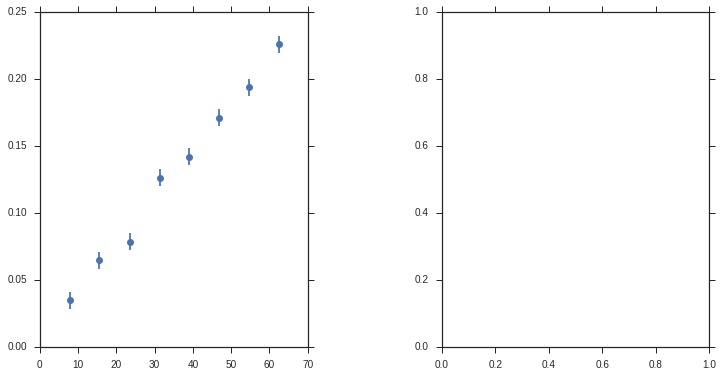

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6)); plt.subplots_adjust(wspace=0.5)
ax1.errorbar(xval, yval, yerr=dy, marker="o", linestyle="")
ax1.plot(xval, my_model(xval,[a_mle, b_mle]), lw=2)
ax1.set_xlabel("Pressure gradient (Pa/m)", fontsize=20)
ax1.set_ylabel("Velocity (m/s)", fontsize=20)
ax1.tick_params(labelsize=16)
ax2.errorbar(xval, yval-my_model(xval,[a_mle, b_mle]), yerr=dy, marker="o", linestyle="")
ax2.set_xlabel("Pressure gradient (Pa/m)",fontsize=20)
ax2.set_ylabel("Velocity residuals (m/s)", fontsize=20)
ax2.axhline(0.0, color='r', linestyle='dotted', lw=2) ## when showing residuals it is useful to also show the 0 line
ax2.tick_params(labelsize=16)
plt.show()

There is no obvious systematic structure in the residuals and the fits look reasonable. Note that, when doing weighted least-squares fitting, the reduced chi-squared returned by dividing the `mlval` parameter by the degrees-of-freedom (6 in this case, since there are 8 data points and 2 free parameters) is close to 1. This also implies a good fit to the data, and that the error bars are not overestimated (you could try doubling the size of the error bars and repeating the procedure and the plots...).

### Mapping out the likelihood using brute force and plotting the likelihood surface

We can map out the way the likelihood changes with the model parameters using computational ‘brute force’, simply by stepping through a grid of the parameters and calculating the likelihood function for each point on the grid. This is computationally expensive but allows us to search the ‘likelihood surface’ quite effectively, to ensure our fit does not get stuck in any local minima. This is not really a concern with the model we are fitting here, but may be quite useful when fitting more complex models to data. The code below will also print the minimum value of negative log-likelihood, which you can compare with the value obtained from minimisation.

In [ ]:
nvals_a = 50
nvals_b = 50
aval = np.linspace(-0.01, 0.03, nvals_a)
bval = np.linspace(0.003, 0.004, nvals_b)
ll = np.zeros((nvals_a,nvals_b))
for i in range(nvals_a): ## x dimension
    for j in range(nvals_b): ## y dimension
        ll[i,j] = LogLikelihood([aval[i], bval[j]], xval, yval, dy)
print "Brute force minimum value", np.amin(ll)

Now we want to make a plot of our likelihood surface. We can do this using matplotlib’s surface function:

In [ ]:
#  First we assign all three variables to their own 2D arrays:
X, Y = np.meshgrid(aval,bval)
Z = np.exp(-ll)
#  Now call the surface function and import the 3d axes module to make some
#  seriously funky plots!
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection="3d")
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.3)
ax.set_xlabel("a",fontsize=20)
ax.set_xlim(-0.01, 0.03)
ax.set_ylabel("b",fontsize=20)
ax.set_ylim(0.003, 0.004)
ax.tick_params(labelsize=14)
plt.show()

You can even rotate and move around the non-inline version of the plot if you wish to explore the shape of the surface!